## Notebook - Chapter06_Reservoir Engineering

In [1]:
# importing basic libraries
import pandas as pd
from pandas import DataFrame
import numpy as np

import requests
import random
import xlrd
import csv
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# visualization/plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  
import matplotlib.pyplot as plt
# setting to default parameters
plt.rcParams.update(plt.rcParamsDefault)

# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("white")
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# matplotlib settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["axes.grid"] = False


In [2]:
# setting seed for model reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [10]:
# setting the destination for the data folder
path = os.path.join(os.getcwd(), "data")
norm_path = os.path.normpath(path)

In [11]:
path

'C:\\Users\\parth.sinha\\machine_learning\\oil_gas_upstream\\Pandey_Ch06_Reservoir_Engineering_Code\\Pandey_Ch06_Reservoir_Engineering_Code\\data'

In [12]:
# defining a function to scrape NDIC data
# https://www.dmr.nd.gov/oilgas/
# data from May 2015 to December 2018 will be used as a training dataset
# data from 2019 will be used as a test dataset

In [13]:
# function to scrape data from NDIC
def scrape_ndic(months_list):
    '''function to scrape NDIC data'''
    # link to website with production data
    website = "https://www.dmr.nd.gov/oilgas/mpr/"
    df = pd.DataFrame()
    # loop through all of the dates in the list
    for period in months_list:
        url = website + period + ".xlsx"
        req = requests.get(url)
        book = xlrd.open_workbook(file_contents=req.content)
        sheet = book.sheet_by_index(0)
        for i in range(1, sheet.nrows):
            temp_value = sheet.cell_value(i, 0)
            year, month, day, hour, minute, second = xlrd.xldate_as_tuple(temp_value, book.datemode)
            sheet._cell_values[i][0] = datetime(year, month, 1).strftime("%m/%Y")
        new_file = (path + '\\'+ period + ".csv")
        csv_file = open(new_file, "w", newline="")
        writer = csv.writer(csv_file)
        # iteration through each row for data pull
        for rownum in range(sheet.nrows):
            writer.writerow(sheet.row_values(rownum))
        csv_file.close()
        df = pd.read_csv(new_file)
        df = df.append(df)
    # dataframe with entire monthly production
    return df

In [14]:
train_list = ["2015_05","2015_06","2015_07","2015_08","2015_09","2015_10","2015_11","2015_12",
    "2016_01","2016_02","2016_03","2016_04","2016_05","2016_06","2016_07","2016_08","2016_09","2016_10","2016_11","2016_12",
    "2017_01","2017_02","2017_03","2017_04","2017_05","2017_06","2017_07","2017_08","2017_09","2017_10","2017_11","2017_12",
    "2018_01","2018_02","2018_03","2018_04","2018_05","2018_06","2018_07","2018_08","2018_09","2018_10","2018_11","2018_12"]
train_prod_data = scrape_ndic(train_list)
train_prod_data["ReportDate"] = pd.to_datetime(train_prod_data["ReportDate"])
#train_prod_data.to_csv("train_prod.csv")

KeyboardInterrupt: 

In [ ]:
test_list = ["2019_01","2019_02","2019_03","2019_04","2019_05","2019_06","2019_07","2019_08","2019_09","2019_10","2019_11","2019_12"]
test_prod_data = scrape_ndic(test_list)
test_prod_data["ReportDate"] = pd.to_datetime(test_prod_data["ReportDate"])
#test_prod_data.to_csv("test_prod.csv")

In [15]:
# ARPS Decline Curve Analysis

def pre_process(df, column):
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.info()
    print(df.columns)
    # descriptive statistics
    df.describe().T
    df.head(15)
    df.nunique()    
    df.dtypes
    df.shape
    # filtering
    df.dropna(inplace=True)
    # drop rows where oil rate is 0
    df = df[(df[column].notnull()) & (df[column] > 0)]
    return df

def plot_production_rate(df):
    '''Plot decline curve using production rates'''
    sns.lineplot(x = df['ReportDate'], y = df['oil_rate'], markers=True, dashes=False, 
                 label="Oil Production",color='blue', linewidth=1.5)
    plt.title('Decline Curve', fontweight='bold', fontsize = 20)
    plt.xlabel('Time', fontweight='bold', fontsize = 15)
    plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
    plt.show()

def decline_curve(curve_type, q_i):
    if curve_type == "exponential":

        def exponential_decline(T, d):
            return q_i * np.exp(-d * T)
        return exponential_decline

    elif curve_type == "hyperbolic":

        def hyperbolic_decline(T, d_i, b):
            return q_i / np.power((1 + b * d_i * T), 1.0 / b)
        return hyperbolic_decline

    elif curve_type == "harmonic":

        def parabolic_decline(T, d_i):
            return q_i / (1 + d_i * T)
        return parabolic_decline

    else:
        raise "Unknown Decline Curve!"


def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))


In [19]:
# reading train and test data

train_prod = pd.read_csv('./data/train_prod.csv')
test_prod = pd.read_csv("./data/test_prod.csv")

# Basic Processing and data exploration
train_prod = pre_process(train_prod, 'Oil')
test_prod = pre_process(test_prod, 'Oil')

# convert time to datetime and set as dataframe index
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])

#bakken_data.set_index("ReportDate", inplace=True)
train_prod["First_Prod_Date"] = train_prod.groupby("API_WELLNO")["ReportDate"].transform('min')
train_prod["Days_Online"] = (train_prod["ReportDate"] - train_prod["First_Prod_Date"]).dt.days 

# find the top 10 wells with highest production (sum)
grouped_data = train_prod.groupby(['API_WELLNO']).sum()
grouped_data = grouped_data.sort_values(by=['Oil'])
grouped_data = grouped_data.nlargest(10, 'Oil').reset_index()

example_wells = grouped_data['API_WELLNO'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684415 entries, 0 to 684414
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ReportDate  684415 non-null  object 
 1   API_WELLNO  684415 non-null  float64
 2   FileNo      684415 non-null  float64
 3   Company     684415 non-null  object 
 4   WellName    684415 non-null  object 
 5   Quarter     684415 non-null  object 
 6   Section     684415 non-null  float64
 7   Township    684415 non-null  float64
 8   Range       684415 non-null  float64
 9   County      684415 non-null  object 
 10  FieldName   684415 non-null  object 
 11  Pool        684415 non-null  object 
 12  Oil         678599 non-null  float64
 13  Wtr         678599 non-null  float64
 14  Days        678599 non-null  float64
 15  Runs        684415 non-null  float64
 16  Gas         678599 non-null  float64
 17  GasSold     684415 non-null  float64
 18  Flared      678599 non-null  float64
 19  La

[3.30250262e+13 3.30530592e+13 3.30530565e+13 3.30530741e+13
 3.30530578e+13 3.30530592e+13 3.30530592e+13 3.30530592e+13
 3.30250218e+13 3.30550014e+13]
API: [33053059210000, 33025021780000]


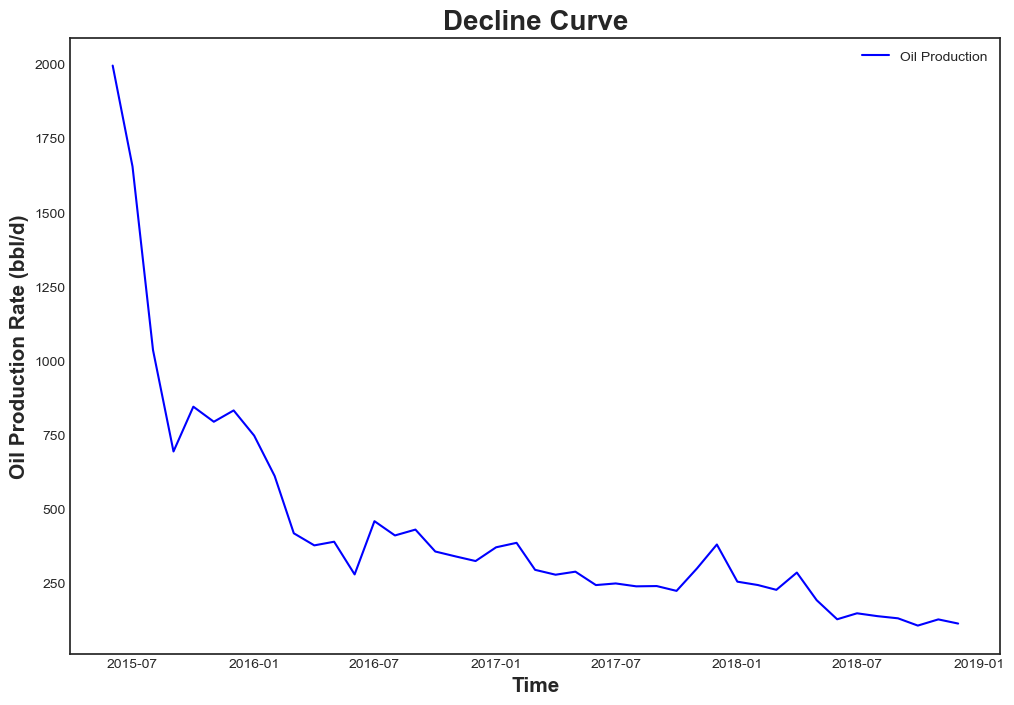

In [20]:
print (example_wells)
demo_well = [33053059210000, 33025021780000]#Choose randomly two wells

print('API:', demo_well)
df_temp = train_prod[train_prod['API_WELLNO'] == demo_well[1]]
df_temp["oil_rate"] = df_temp["Oil"] / df_temp["Days"]
df_temp['date_delta'] = (df_temp['ReportDate'] - df_temp['ReportDate'].min())/np.timedelta64(1,'D')
plot_production_rate(df_temp)

In [21]:
df_temp = df_temp[['date_delta', 'oil_rate']]
data = df_temp.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_train, q = data.T
print(T_train)
print(q)

[   0.   30.   61.   92.  122.  153.  183.  214.  245.  274.  305.  335.
  366.  396.  427.  458.  488.  519.  549.  580.  611.  639.  670.  700.
  731.  761.  792.  823.  853.  884.  914.  945.  976. 1004. 1035. 1065.
 1096. 1126. 1157. 1188. 1218. 1249. 1279.]
[1994.9375     1654.4516129  1035.4         693.36666667  844.4516129
  793.62068966  831.80645161  746.90322581  610.75862069  417.38095238
  376.63333333  388.96774194  278.68965517  458.23076923  410.12903226
  429.86666667  355.96774194  339.26666667  323.80769231  370.125
  385.21428571  294.12903226  277.66666667  287.93548387  242.73333333
  248.22580645  238.48387097  239.4137931   223.16129032  299.1
  379.57142857  254.24137931  242.88461538  226.68965517  284.86206897
  191.76666667  127.36666667  147.5483871   137.90322581  130.6
  106.09677419  126.96551724  112.93548387]


In [41]:
T_train

array([   0.,   30.,   61.,   92.,  122.,  153.,  183.,  214.,  245.,
        274.,  305.,  335.,  366.,  396.,  427.,  458.,  488.,  519.,
        549.,  580.,  611.,  639.,  670.,  700.,  731.,  761.,  792.,
        823.,  853.,  884.,  914.,  945.,  976., 1004., 1035., 1065.,
       1096., 1126., 1157., 1188., 1218., 1249., 1279.])

In [39]:
# Assumption - determine qi from max value of first 3 months of production
df_initial_period = df_temp.head(3)
qi = df_initial_period['oil_rate'].max()

exp_decline = decline_curve("exponential", qi)
hyp_decline = decline_curve("hyperbolic", qi)
har_decline = decline_curve("harmonic", qi)

popt_exp, pcov_exp = curve_fit(exp_decline, T_train, q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T_train, q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T_train, q, method="trf")

print("L2 Norm of exponential decline: ", L2_norm(exp_decline(T_train, popt_exp[0]), q))
print("L2 Norm of hyperbolic decline decline: ",L2_norm(hyp_decline(T_train, popt_hyp[0], popt_hyp[1]), q))
print("L2 Norm of harmonic decline decline: ", L2_norm(har_decline(T_train, popt_har[0]), q))

L2 Norm of exponential decline:  10167505.41462357
L2 Norm of hyperbolic decline decline:  309675.9298070083
L2 Norm of harmonic decline decline:  361356.90904455684


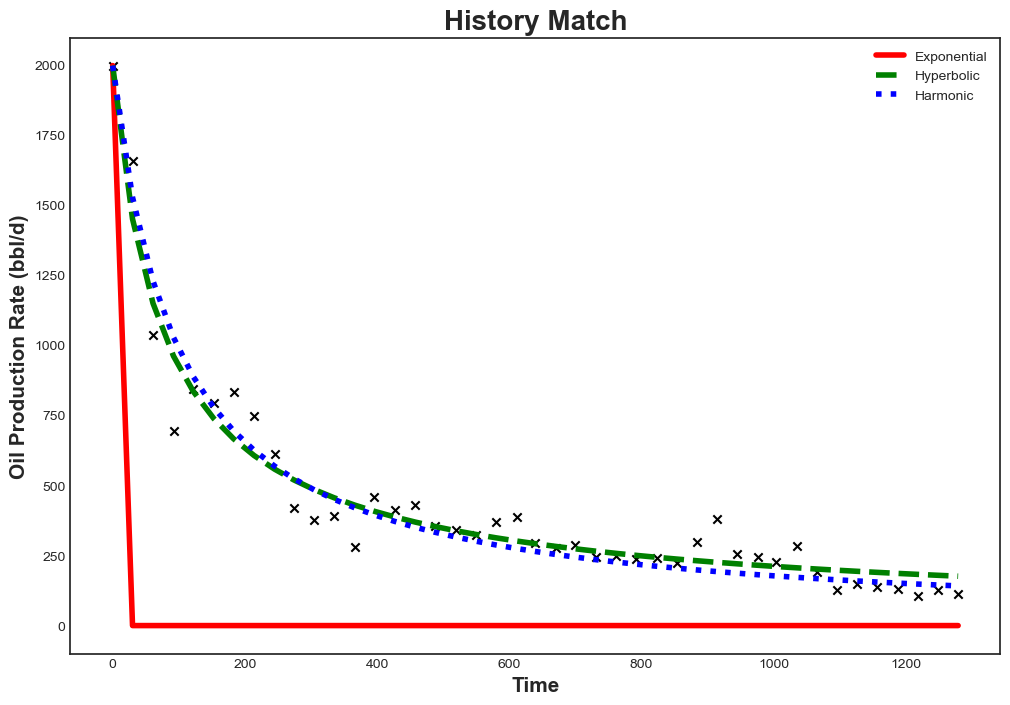

In [40]:
# Predict
plt.scatter(T_train, q, color="black", marker="x", alpha=1)
pred_exp = exp_decline(T_train, popt_exp[0])
pred_hyp = hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_train, popt_har[0])
plt.plot(T_train, pred_exp, color="red", label="Exponential", linewidth = 4)
plt.plot(T_train, pred_hyp, color="green", label="Hyperbolic", linestyle="--", linewidth = 4)
plt.plot(T_train, pred_har, color="blue", label="Harmonic", linestyle = ':', linewidth = 4)
plt.title('History Match', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

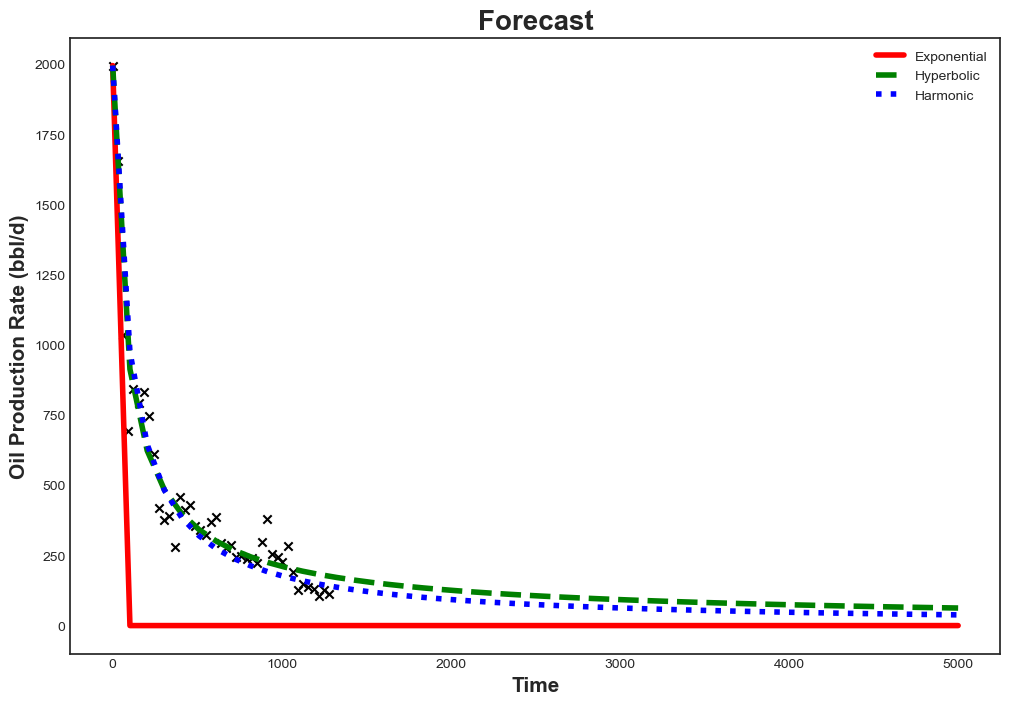

In [42]:
# Forecast
max_time_forecast = 5000
T_pred = np.linspace(min(T_train), max_time_forecast)
plt.scatter(T_train, q, color="black", marker="x", alpha=1)
pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])
plt.plot(T_pred, pred_exp, color="red", label="Exponential", linewidth = 4)
plt.plot(T_pred, pred_hyp, color="green", label="Hyperbolic", linestyle="--", linewidth = 4)
plt.plot(T_pred, pred_har, color="blue", label="Harmonic", linestyle = ':', linewidth = 4)
plt.title('Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [43]:
# validation procedure

print('API:', demo_well[1])
df_temp_test = test_prod[test_prod['API_WELLNO'] == demo_well[1]]
df_temp_test["oil_rate"] = df_temp_test["Oil"] / df_temp_test["Days"]
df_temp_test['date_delta'] = (df_temp_test['ReportDate'] - df_temp_test['ReportDate'].min())  / np.timedelta64(1,'D')
print(df_temp_test)
df_temp_test = df_temp_test[['date_delta', 'oil_rate']]
data_test = df_temp_test.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_test, q_test = data_test.T

#T_test = np.concatenate(T_train, T)
print(T_test)
print(q_test)

API: 33025021780000
       ReportDate        API_WELLNO   FileNo  \
9237   2019-01-01 33025021780000.00 25736.00   
26666  2019-02-01 33025021780000.00 25736.00   
44161  2019-03-01 33025021780000.00 25736.00   
61730  2019-04-01 33025021780000.00 25736.00   
79421  2019-05-01 33025021780000.00 25736.00   
97225  2019-06-01 33025021780000.00 25736.00   
115149 2019-07-01 33025021780000.00 25736.00   
133202 2019-08-01 33025021780000.00 25736.00   
151359 2019-09-01 33025021780000.00 25736.00   
169616 2019-10-01 33025021780000.00 25736.00   
187967 2019-11-01 33025021780000.00 25736.00   

                                   Company              WellName Quarter  \
9237    ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
26666   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
44161   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
61730   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
79421   ENERPLUS RESOUR

In [44]:
time = pd.date_range(start='6/1/2015', periods= 54, freq='MS')
time
T_Test2 = T_train[-1] + T_test
len(T_train)
pred_hyp =  hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_hyp2 = hyp_decline(T_Test2, popt_hyp[0], popt_hyp[1])
print(pred_hyp)
print(pred_hyp2)
# forecast
q_orig = np.append(q, q_test)
forecast = np.concatenate([pred_hyp, pred_hyp2])

[1994.9375     1448.62576769 1148.04118258  960.09163545  833.84616225
  737.35543188  665.22003708  605.68592891  557.07659255  518.96359759
  484.25039058  455.32203053  429.27541859  407.09626662  386.75357098
  368.59446655  352.7743087   337.96976622  324.92783234  312.60103445
  301.29356509  291.85138739  282.15313248  273.44126582  265.05961138
  257.4869443   250.16247676  243.2974968   237.05044029  230.96768996
  225.41034944  219.97896698  214.8377671   210.42390589  205.77211507
  201.48820471  197.26992997  193.37505342  189.53031762  185.8559714
  182.45153462  179.07983021  175.94945401]
[175.94945401 172.84316906 170.14306204 167.26370168 164.58109032
 161.91023273 159.41799898 156.93297727 154.53476689 152.29219418
 150.05154926]


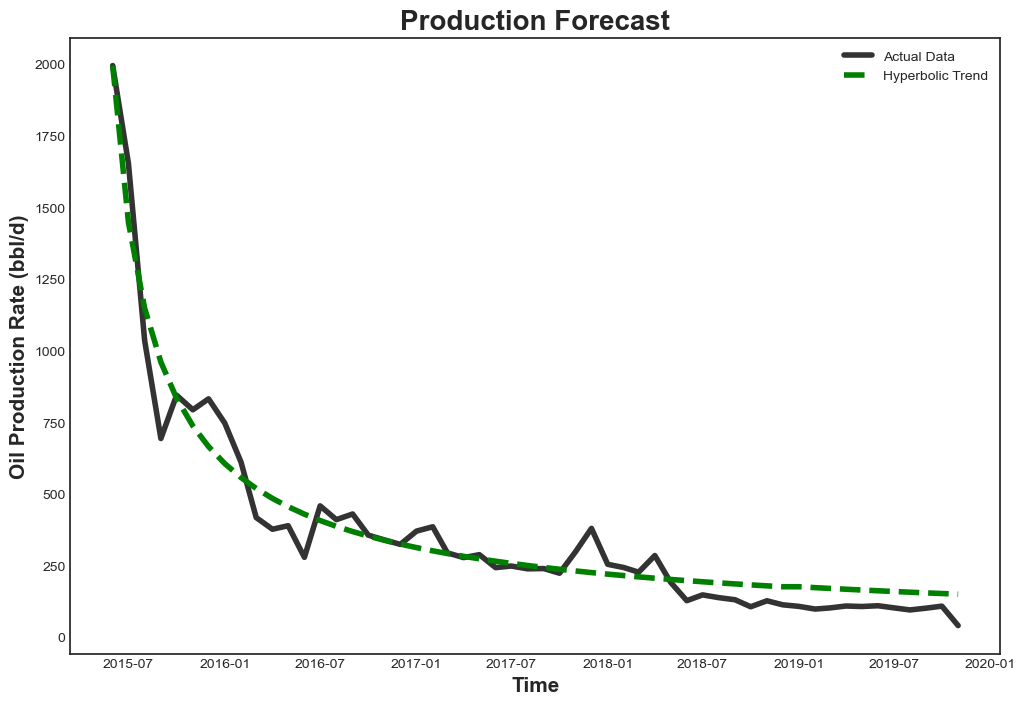

In [45]:
# hyperbolic forecast - plot
plt.plot(time, q_orig, color="black", alpha = 0.8, label='Actual Data', linewidth = 4)
plt.plot(time, forecast, color="green", label="Hyperbolic Trend", linewidth = 4, linestyle="--")
plt.title('Production Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [46]:
rmse = sqrt(mean_squared_error(q_orig, forecast))
print("RMSE - Hyperbolic Method:", rmse)

RMSE - Hyperbolic Method: 81.41922172634314


## ARIMA MODEL BASED DCA

In [50]:
def plot_production_series(series):
    plt.figure(figsize=(10, 6))
    plt.plot(series, color = 'blue')
    plt.title("Oil Production Decline")
    plt.xlabel("Year")
    plt.ylabel("Production Rate (bbls/d)")
    plt.show()

In [51]:
# data 
train_prod = pd.read_csv('./data/train_prod.csv')
test_prod = pd.read_csv("./data/test_prod.csv")
print('Training Data:\n', train_prod.head(10))
print('\n')
print('Test Data:\n', train_prod.head(10))

Training Data:
    Unnamed: 0  ReportDate        API_WELLNO   FileNo  \
0           0  2015-05-01 33053043310000.00 23615.00   
1           1  2015-05-01 33053038990000.00 22021.00   
2           2  2015-05-01 33053048330000.00 25091.00   
3           3  2015-05-01 33053050010000.00 25645.00   
4           4  2015-05-01 33053048340000.00 25092.00   
5           5  2015-05-01 33053050000000.00 25644.00   
6           6  2015-05-01 33053039010000.00 22023.00   
7           7  2015-05-01 33053042390000.00 23319.00   
8           8  2015-05-01 33053042400000.00 23320.00   
9           9  2015-05-01 33053042380000.00 23302.00   

                       Company                  WellName Quarter  Section  \
0  MUREX PETROLEUM CORPORATION   AMBER ELIZABETH  36-25H    SESW    36.00   
1         STATOIL OIL & GAS LP          BILL  14-23 2TFH    SWSW    11.00   
2         STATOIL OIL & GAS LP            BILL  14-23 3H    NWNE    14.00   
3         STATOIL OIL & GAS LP          BILL  14-23 4TFH   

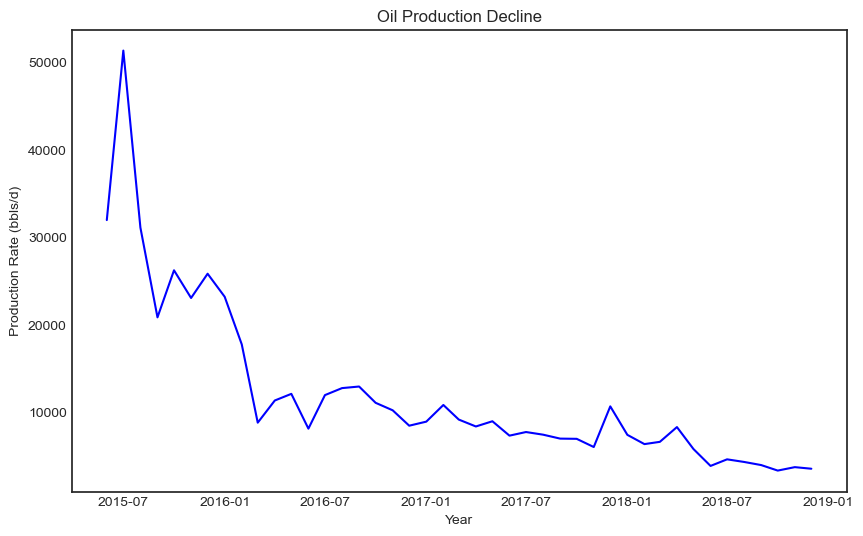

In [52]:
# Preprocessing on train data
# well selection for demo - time series
train_prod = train_prod[train_prod["API_WELLNO"] == 33025021780000.0]
train_prod.drop("Unnamed: 0", axis=1, inplace=True)
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
train_prod.set_index("ReportDate", inplace=True)
train_prod.nunique()

# converting data from dataframe to series - oil production
timeseries_train= train_prod["Oil"]
timeseries_train.head()
plot_production_series(timeseries_train)

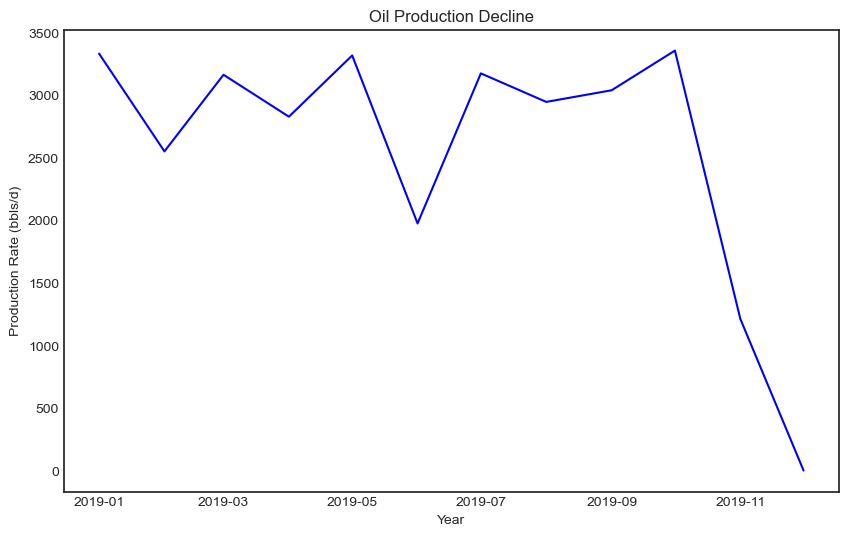

In [53]:
# Preprocessing on test data
# well selection for demo - time series
test_prod = test_prod[test_prod["API_WELLNO"] == 33025021780000.0]
test_prod.drop("Unnamed: 0", axis=1, inplace=True)
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])
test_prod.set_index("ReportDate", inplace=True)
test_prod.nunique()

# time series is production volumes and not flow rates
timeseries_test = test_prod["Oil"]
timeseries_test.head()
plot_production_series(timeseries_test)

In [54]:
# ADF - Augmented Dickey-Fuller unit root test - to test stationarity
print("p-value:", adfuller(timeseries_train.dropna())[1])

p-value: 0.812170915513829


In [55]:
# Perform Dickey-Fuller test:
def dickey_ful_test(series):
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(series, autolag="AIC")
    df_output = pd.Series(df_test[0:4],index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

In [56]:
def stationary_test_plot(metric, data_series, method):
    plt.figure(figsize=(10, 6))
    orig = plt.plot(data_series, label="Original", color = 'blue')
    metric = plt.plot(metric, label= method, color ='red')
    plt.legend(loc="best")
    plt.title(method)
    plt.xlabel('Time (yyyy-mm)')
    plt.ylabel('Oil Production (bbls)')
    plt.show()

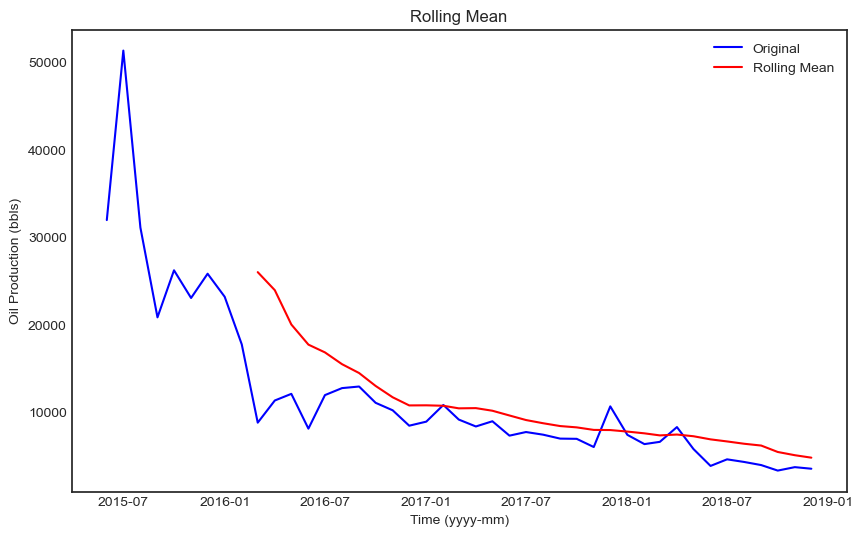

Results of Dickey-Fuller Test:
Test Statistic                -0.82
p-value                        0.81
#Lags Used                     9.00
Number of Observations Used   33.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.95
Critical Value (10%)          -2.62
dtype: float64


In [78]:

def stationary_test(data_series, method):
    rolling_mean = data_series.rolling(10).mean()
    stationary_test_plot(rolling_mean, data_series, method)
    dickey_ful_test(data_series)

# test if the time series data is stationary or not
stationary_test(timeseries_train, "Rolling Mean")

In [58]:
def plot_time_series(y_axis, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_axis, label = y_label, color = 'blue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

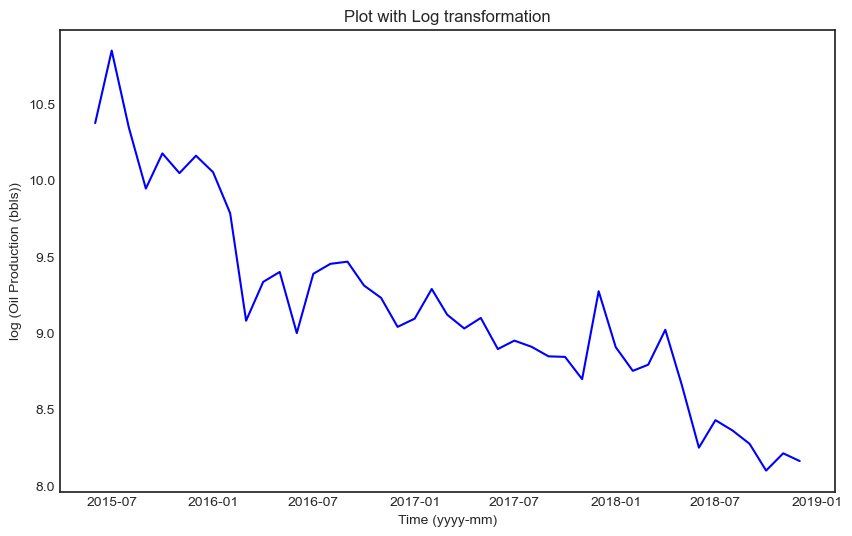

In [59]:
# y axis transformation - log(data)
ts_log = np.log(timeseries_train)
plot_time_series(ts_log, "Time (yyyy-mm)", "log (Oil Production (bbls))", "Plot with Log transformation")

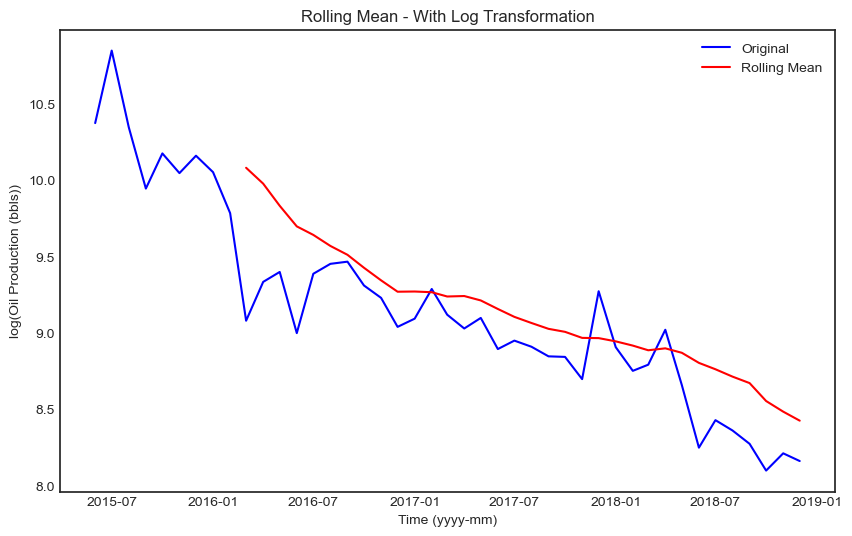

In [60]:
# rolling mean estimation and plot
rolling_mean_log = ts_log.rolling(10).mean()

plt.figure(figsize=(10, 6))
orig = plt.plot(ts_log, label="Original", color = 'blue')
mean = plt.plot(rolling_mean_log, label="Rolling Mean", color ='red')
plt.title("Rolling Mean - With Log Transformation")
plt.xlabel('Time (yyyy-mm)')
plt.ylabel('log(Oil Production (bbls))')
plt.legend(loc="best")
plt.show()


In [61]:
# plot of difference between log(data) and moving average
diff_log_rolmean = ts_log - rolling_mean_log
diff_log_rolmean.dropna(inplace=True)

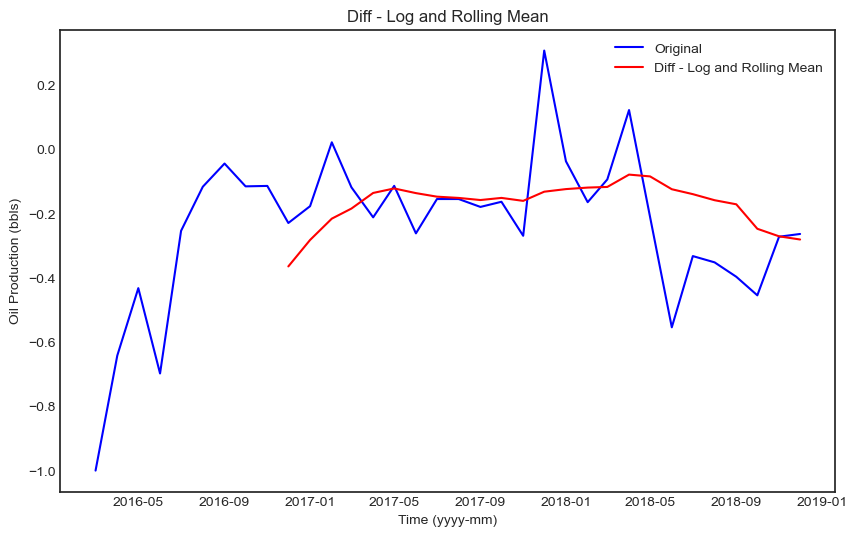

Results of Dickey-Fuller Test:
Test Statistic                -1.36
p-value                        0.60
#Lags Used                     7.00
Number of Observations Used   26.00
Critical Value (1%)           -3.71
Critical Value (5%)           -2.98
Critical Value (10%)          -2.63
dtype: float64


In [62]:
stationary_test(diff_log_rolmean, "Diff - Log and Rolling Mean")

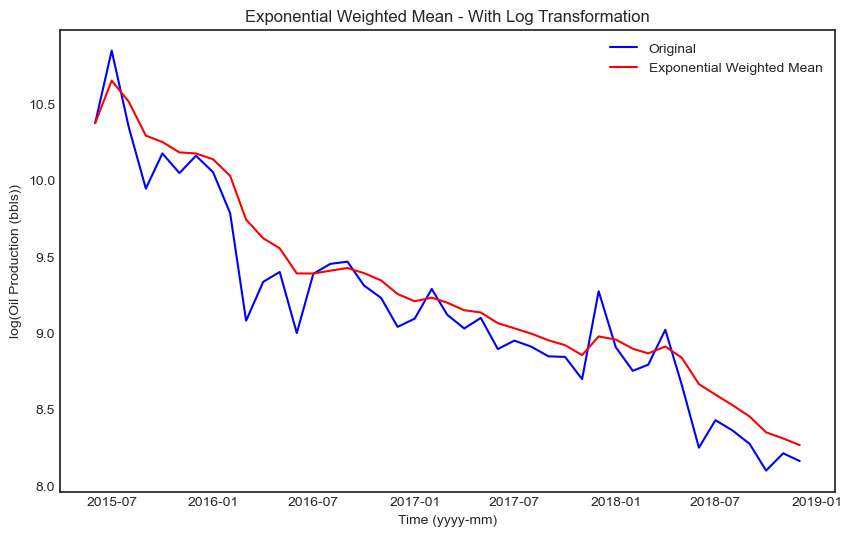

In [63]:
# exponential weighted calculations
weighted_avg_exp = ts_log.ewm(halflife=2).mean()
plt.figure(figsize=(10, 6))

orig = plt.plot(ts_log, label="Original", color = 'blue')
mean = plt.plot(weighted_avg_exp, label="Exponential Weighted Mean", color ='red')
plt.title("Exponential Weighted Mean - With Log Transformation")
plt.xlabel('Time (yyyy-mm)')
plt.ylabel('log(Oil Production (bbls))')
plt.legend(loc="best")
plt.show()

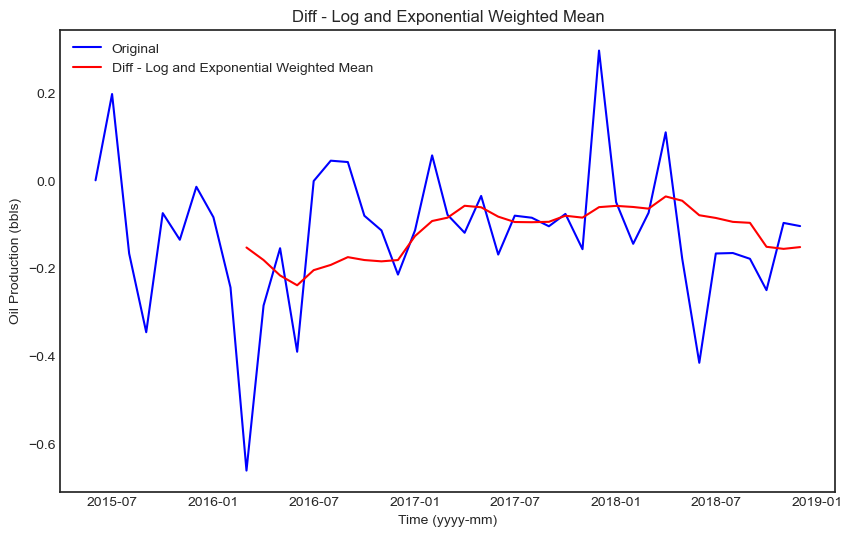

Results of Dickey-Fuller Test:
Test Statistic                -4.95
p-value                        0.00
#Lags Used                     0.00
Number of Observations Used   42.00
Critical Value (1%)           -3.60
Critical Value (5%)           -2.93
Critical Value (10%)          -2.60
dtype: float64


In [64]:
diff_log_ewm = ts_log - weighted_avg_exp
stationary_test(diff_log_ewm, "Diff - Log and Exponential Weighted Mean")

In [65]:
# First Order differencing - n this technique, we take the difference of the observation at a particular instant with 
# that at the previous instant. This mostly works well in improving stationarity

# Differencing can help stabilize the mean of the time series by removing changes in the level of a time series,
# and so eliminating (or reducing) trend and seasonality
# https://machinelearningmastery.com/difference-time-series-dataset-python/

first_order_diff = ts_log - ts_log.shift()


<Figure size 1000x600 with 0 Axes>

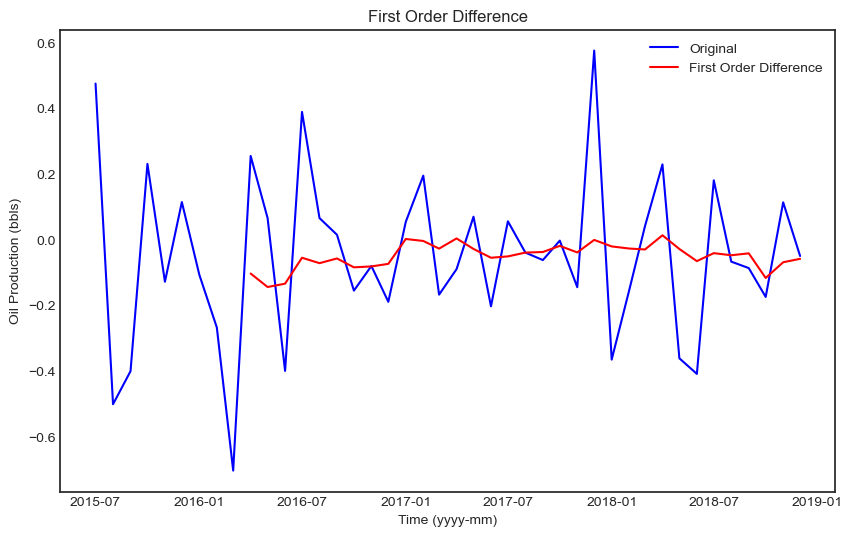

Results of Dickey-Fuller Test:
Test Statistic                -7.22
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   40.00
Critical Value (1%)           -3.61
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [66]:
first_order_diff.dropna(inplace=True)
plt.figure(figsize=(10, 6))
stationary_test(first_order_diff, "First Order Difference")

In [67]:
ts_log_diff_active = first_order_diff

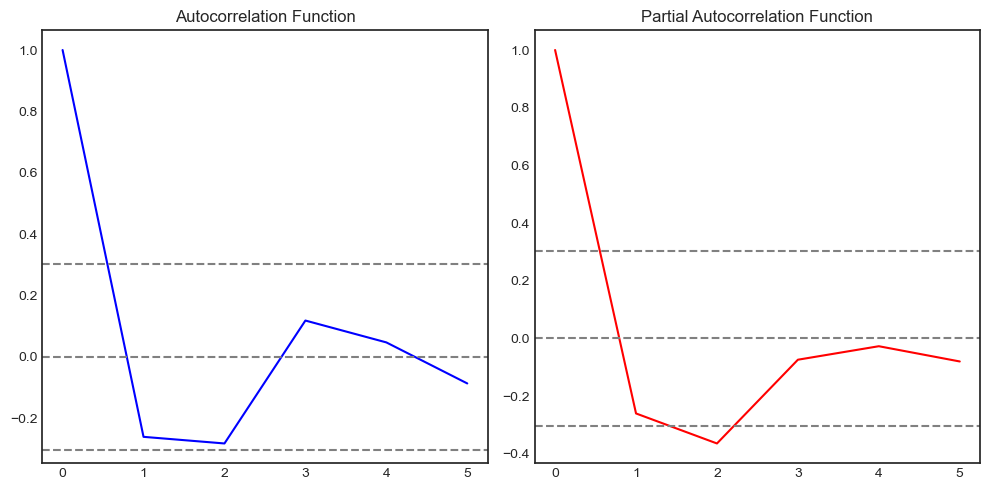

In [68]:

lag_acf = acf(ts_log_diff_active, nlags=5)
lag_pacf = pacf(ts_log_diff_active, nlags=5, method="ols")
plt.figure(figsize=(10, 5))

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf, color = 'blue')
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, color = 'red')
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


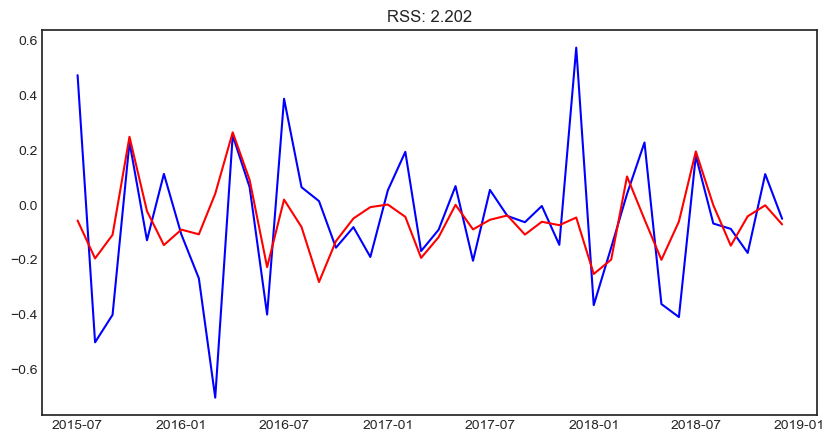

In [69]:
# Auto-Regressive Model (p=2, d=1, q=0)
model_AR = ARIMA(ts_log, order=(2, 1, 0))
results_ARIMA_AR = model_AR.fit(disp=-1)
plt.figure(figsize=(10, 5))
plt.plot(ts_log_diff_active, color = 'blue')
plt.plot(results_ARIMA_AR.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA_AR.fittedvalues - first_order_diff) ** 2))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


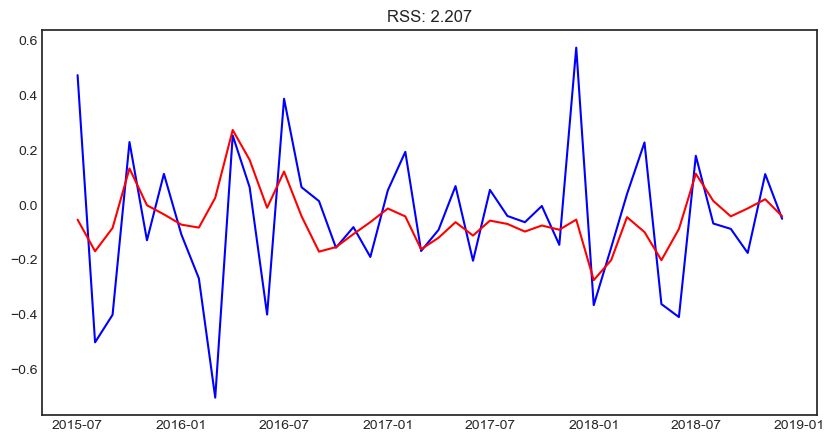

In [70]:
# Moving Average Model (p=0, d=1, q=2)
model_MA = ARIMA(ts_log, order=(0, 1, 2))
results_ARIMA_MA = model_MA.fit(disp=-1)
plt.figure(figsize=(10, 5))
plt.plot(ts_log_diff_active, color = 'blue')
plt.plot(results_ARIMA_MA.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA_MA.fittedvalues - first_order_diff) ** 2))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                  D.Oil   No. Observations:                   42
Model:                 ARIMA(2, 1, 2)   Log Likelihood                   4.240
Method:                       css-mle   S.D. of innovations              0.213
Date:                Wed, 16 Dec 2020   AIC                              3.520
Time:                        22:02:19   BIC                             13.946
Sample:                    07-01-2015   HQIC                             7.342
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0552      0.015     -3.782      0.000      -0.084      -0.027
ar.L1.D.Oil    -0.6431      0.290     -2.216      0.027      -1.212      -0.074
ar.L2.D.Oil     0.0626      0.279      0.224    

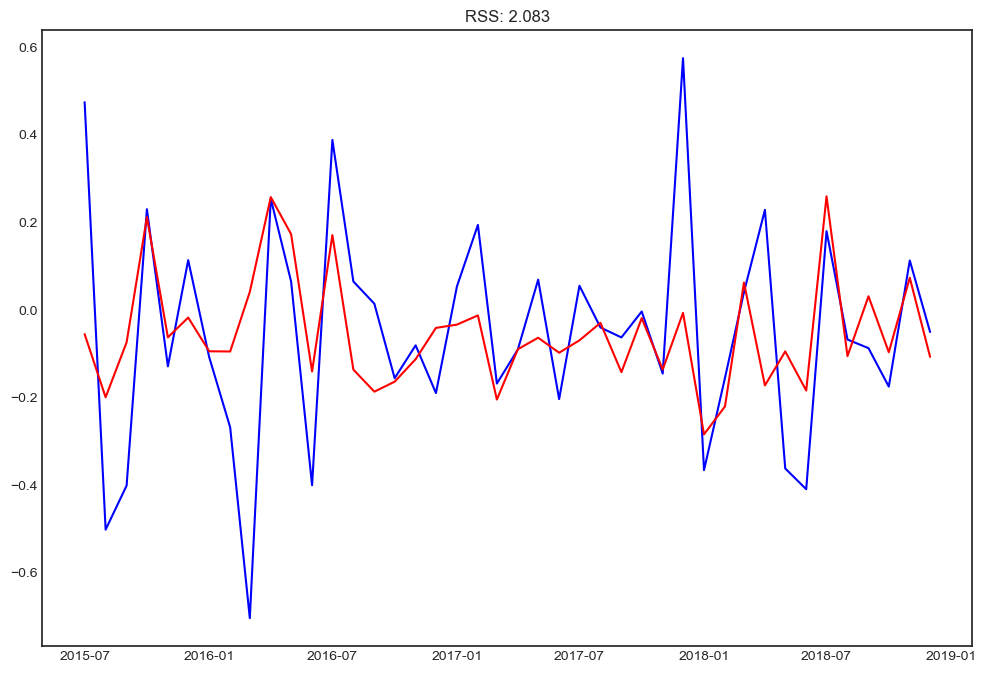

In [71]:
# Combined ARIMA model (p=2, d=1, q=2)
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
plt.plot(ts_log_diff_active, color = 'blue')
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA.fittedvalues - first_order_diff) ** 2))
plt.show()

<Figure size 1000x500 with 0 Axes>

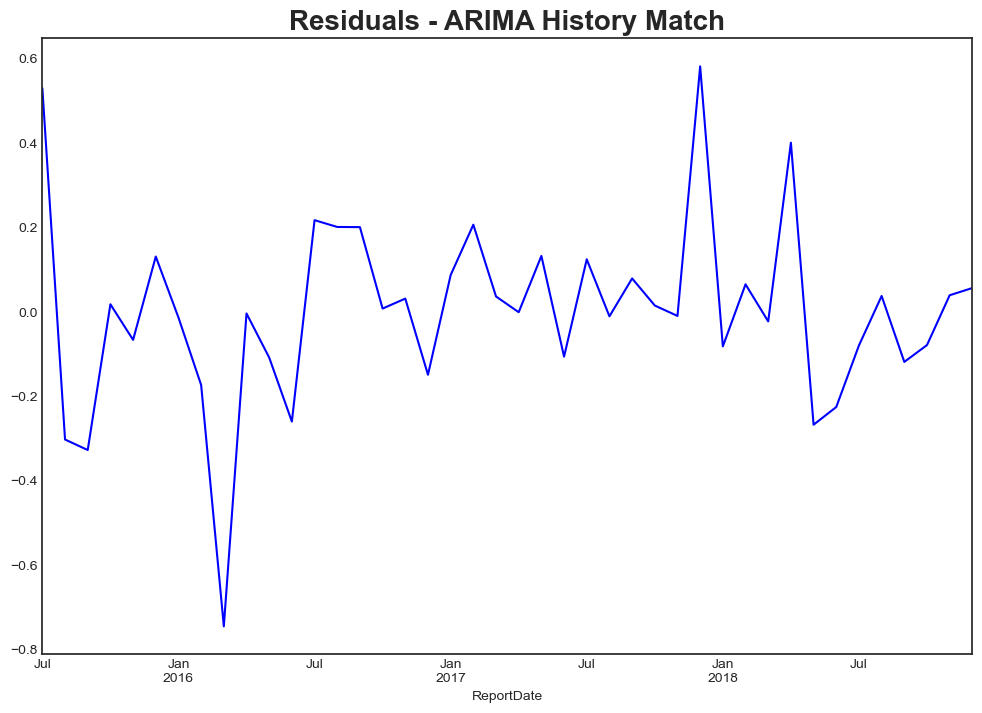

In [72]:
# residual and kde plot
plt.figure(figsize=(10, 5))# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(legend=None, color = 'blue')
plt.title('Residuals - ARIMA History Match', fontweight='bold', fontsize = 20)
plt.show()

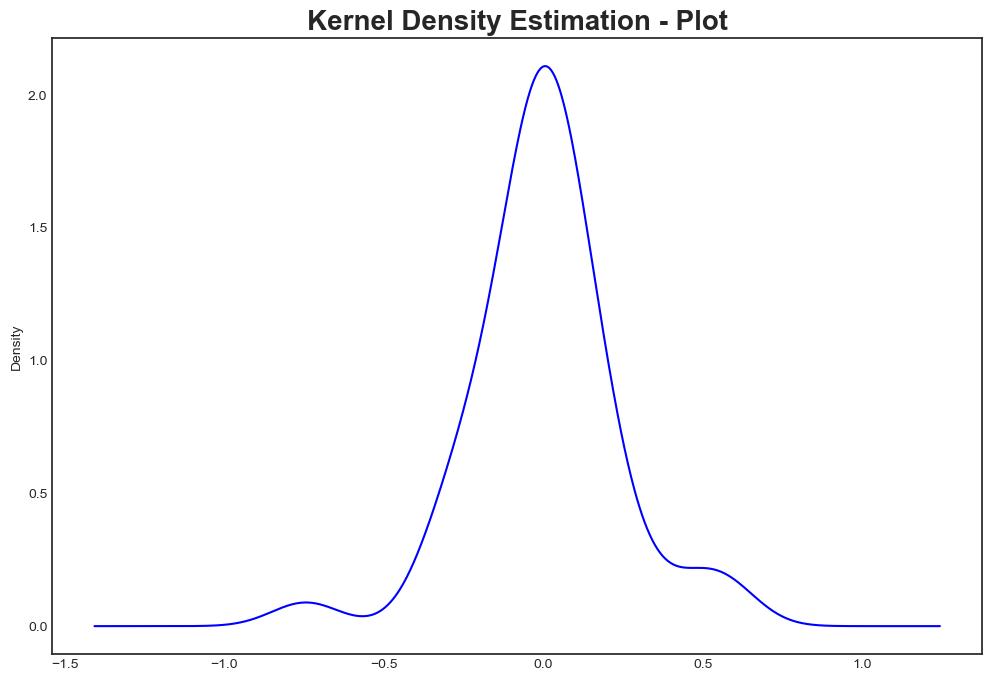

          0
count 42.00
mean   0.00
std    0.23
min   -0.74
25%   -0.10
50%    0.00
75%    0.09
max    0.58


In [73]:
residuals.plot(kind='kde', legend=None, color = 'blue')
plt.title('Kernel Density Estimation - Plot', fontweight='bold', fontsize = 20)
plt.show()
print(residuals.describe())

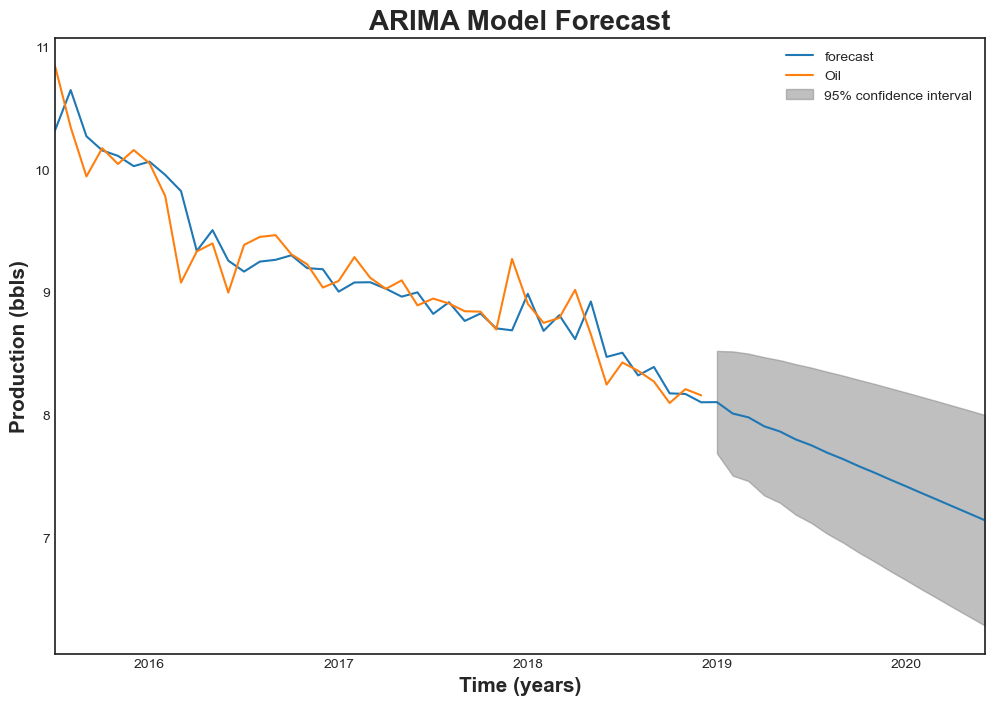

In [74]:

# forecast - ARIMA model
results_ARIMA.plot_predict(1, 60)
plt.title('ARIMA Model Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time (years)', fontweight='bold', fontsize = 15)
plt.ylabel('Production (bbls)', fontweight='bold', fontsize = 15)
plt.show()

In [75]:
# Predictions converted to right units - ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)

ReportDate
2015-06-01   31919.00
2015-07-01   48534.77
2015-08-01   24082.51
2015-09-01   14977.30
2015-10-01   23296.49
2015-11-01   19239.19
2015-12-01   21183.82
2016-01-01   17308.35
2016-02-01   12042.33
2016-03-01    6209.48
2016-04-01   10356.60
2016-05-01   13140.46
2016-06-01    7653.79
2016-07-01   13384.11
2016-08-01   12464.78
2016-09-01   10491.66
2016-10-01    7621.37
2016-11-01    6282.31
2016-12-01    4987.86
2017-01-01    5089.15
2017-02-01    6102.96
2017-03-01    4204.77
2017-04-01    3511.80
2017-05-01    3531.74
2017-06-01    2613.24
2017-07-01    2576.37
2017-08-01    2403.18
2017-09-01    1958.00
2017-10-01    1914.74
2017-11-01    1445.32
2017-12-01    2550.79
2018-01-01    1332.06
2018-02-01     915.38
2018-03-01    1014.57
2018-04-01    1073.13
2018-05-01     679.80
2018-06-01     375.61
2018-07-01     582.74
2018-08-01     490.19
2018-09-01     463.49
2018-10-01     353.29
2018-11-01     425.62
2018-12-01     363.61
dtype: float64


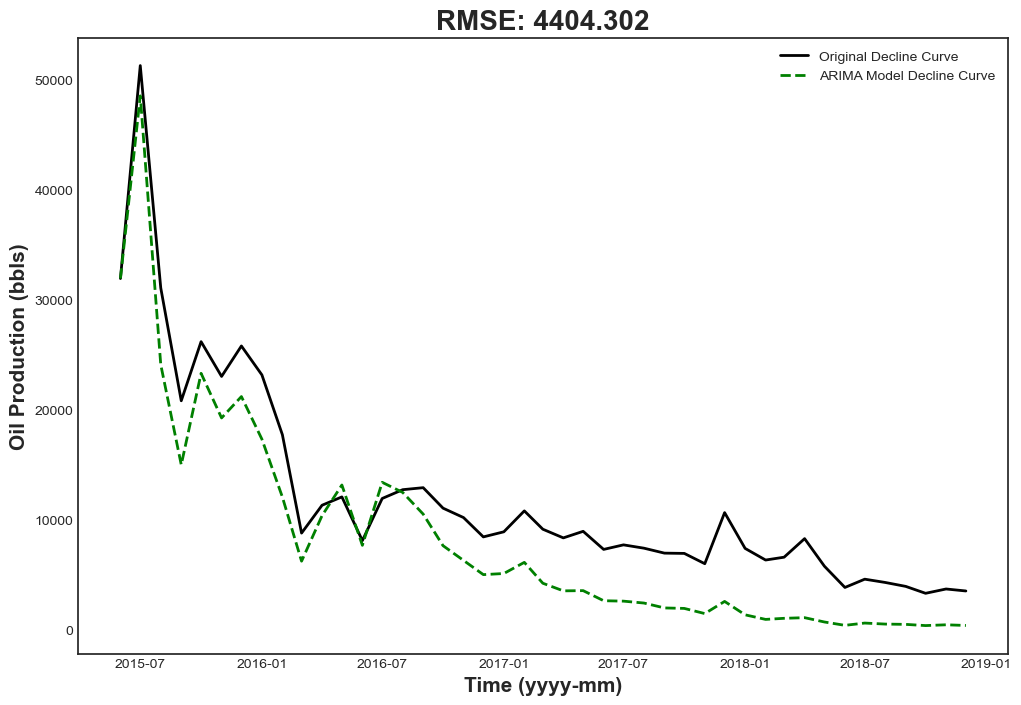

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(timeseries_train, linewidth = 2, color = 'black')
plt.plot(predictions_ARIMA, linestyle = "--", color = 'green', linewidth = 2)
plt.title("RMSE: %.3f" % np.sqrt(sum((predictions_ARIMA - timeseries_train) ** 2) / len(timeseries_train)), fontweight='bold', fontsize = 20)
plt.gca().legend(("Original Decline Curve", "ARIMA Model Decline Curve"))
plt.xlabel('Time (yyyy-mm)', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontweight='bold', fontsize = 15)
plt.show()

In [82]:
forecast = results_ARIMA.forecast(steps=12)[0]
forecast

array([8.10524379, 8.01262381, 7.98150369, 7.90851263, 7.86629893,
       7.801671  , 7.75338446, 7.69318554, 7.64167052, 7.58382511,
       7.53059443, 7.4739997 ])

In [83]:
# invert the differenced forecast results to covert to right units
X = timeseries_train.values
history = [x for x in X]
months_in_year = 12
Month = 1
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

for yhat in forecast:
    inverted = inverse_difference(history, yhat, months_in_year)
    print(Month, inverted)
    history.append(inverted)
    Month += 1

history
forecast_12_months = history[-12:] # last 12 forecasted values
predictions_ARIMA = predictions_ARIMA.to_numpy()
forecast_12_months = np.array(forecast_12_months)

1 7381.105243792404
2 6323.012623809836
3 6581.981503686114
4 8268.90851263102
5 5760.866298932073
6 3828.801670995454
7 4581.7533844628
8 4282.693185536087
9 3925.641670519072
10 3296.5838251075916
11 3689.5305944265583
12 3508.4739996997787


In [84]:
print(predictions_ARIMA)
print(forecast_12_months)

[31919.         48534.76975539 24082.50984656 14977.30028586
 23296.48661037 19239.18731814 21183.8163057  17308.3485008
 12042.32526911  6209.47901981 10356.60043226 13140.46130005
  7653.78973465 13384.10993893 12464.7840252  10491.66221221
  7621.36889791  6282.30888771  4987.86037688  5089.14868605
  6102.96371956  4204.7685107   3511.80197225  3531.74128161
  2613.23911259  2576.36723634  2403.1765265   1958.0007682
  1914.73565054  1445.32215291  2550.79430144  1332.0582047
   915.37678817  1014.57049511  1073.13059413   679.8024399
   375.60808443   582.73747109   490.19292268   463.48974996
   353.28538041   425.61665471   363.61097685]
[7381.10524379 6323.01262381 6581.98150369 8268.90851263 5760.86629893
 3828.801671   4581.75338446 4282.69318554 3925.64167052 3296.58382511
 3689.53059443 3508.4739997 ]


In [85]:
arima_model_results = np.concatenate((predictions_ARIMA, forecast_12_months))
arima_model_results

array([31919.        , 48534.76975539, 24082.50984656, 14977.30028586,
       23296.48661037, 19239.18731814, 21183.8163057 , 17308.3485008 ,
       12042.32526911,  6209.47901981, 10356.60043226, 13140.46130005,
        7653.78973465, 13384.10993893, 12464.7840252 , 10491.66221221,
        7621.36889791,  6282.30888771,  4987.86037688,  5089.14868605,
        6102.96371956,  4204.7685107 ,  3511.80197225,  3531.74128161,
        2613.23911259,  2576.36723634,  2403.1765265 ,  1958.0007682 ,
        1914.73565054,  1445.32215291,  2550.79430144,  1332.0582047 ,
         915.37678817,  1014.57049511,  1073.13059413,   679.8024399 ,
         375.60808443,   582.73747109,   490.19292268,   463.48974996,
         353.28538041,   425.61665471,   363.61097685,  7381.10524379,
        6323.01262381,  6581.98150369,  8268.90851263,  5760.86629893,
        3828.801671  ,  4581.75338446,  4282.69318554,  3925.64167052,
        3296.58382511,  3689.53059443,  3508.4739997 ])

In [86]:
timeseries_train.values # oil rate - train
timeseries_test # oil rate - test
forecast_12_months # oil rate - forecast

ts_np = timeseries_train.to_numpy()
ts_forecast = np.array(forecast_12_months)
ts_test_np = timeseries_test.to_numpy()

actual = np.concatenate([ts_np, ts_test_np])
actual = np.delete(actual, -1)
actual

forecast = np.concatenate([predictions_ARIMA, ts_forecast])
forecast = np.delete(forecast, -1)
forecast

time = pd.date_range(start='6/1/2015', periods= 54, freq='MS')

In [87]:
rmse = sqrt(mean_squared_error(actual, forecast))
print("RMSE - ARIMA Method:", rmse)

RMSE - ARIMA Method: 4141.433178244293
